In [1]:
import pickle
import numpy as np
import pandas as pd
import pydap.client
import matplotlib.pyplot as plt
from os import path
from skypy.utils import package_directory, add_to_pickel_file, open_dap_url_constructor, get_ceres_dap_url_hourly_cadence
from skypy.telescopes.hst import HubbleObservation
%matplotlib inline

/anaconda3/envs/skypy/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Volumes/CODE/Hubble/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/anaconda3/envs/skypy/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Volumes/CODE/Hubble/grp/hst/cdbs/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/anaconda3/envs/skypy/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Volumes/CODE/Hubble/grp/hst/cdbs/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Path to all of the HST data from MAST
data_path = package_directory('data', 'MDRIZSKY.csv')

In [3]:
# Parse the data into a pandas dataframe
master_data_frame = pd.read_csv(data_path)

In [4]:
# Choose only exposures that are taken during the day
data_sun_selection = master_data_frame.loc[master_data_frame['SUN_ALT'] > 0]

In [5]:
# Choose only GOODS fields for now
data_goods_selection = data_sun_selection[data_sun_selection['Target Name'].str.contains(
    "GOODS")]

In [6]:
# Choose only exposures in the X bandpass (here is it F606W)
data_final_filter_selection = data_goods_selection[data_goods_selection['FILTER1'].str.contains(
    "F850LP")]

In [7]:
# Reset the index of the data set
data_final_selection = data_final_filter_selection
df_to_use = data_final_selection.reset_index()

In [8]:
# Pick the observation to get ceres data for
i = 33

In [9]:
# Get all of the HST info from one exposure and initiate the HSTObs class
hst_obs = HubbleObservation(df_to_use.loc[i])

In [10]:
# Get the file extension batch number for the CERES data base based on the HST obs date
code_40 = open_dap_url_constructor(hst_obs.start_times)

In [11]:
if code_40 == -999:
            pass
else:
    # Otherwise get the CERES URL in order to import the data remotely
    search_url = get_ceres_dap_url_hourly_cadence(code_40,
                                                  hst_obs.start_times)

In [12]:
# Define where to store the data
pickel_path = "/Users/physarah/Desktop"

In [13]:
# Define the file name
pickel_filename = "FF850LP_{}".format(hst_obs.mid_times.strftime("%d%m%y_%H%M%S"))

In [14]:
# If the file already exists, then don't download it again
if path.exists(pickel_path + "/" + pickel_filename + ".pickle"):
    print("This already exists")

else:
    # Otherwise get the closest CERES timestep
    hst_hour = hst_obs.mid_times.hour - 1

    # Open the data set remotly
    try:
        dataset = pydap.client.open_url(search_url)

        # Get a subset of the data
        subset = dataset['init_all_toa_sw_up'][hst_hour, :, :]

        # Pickle the result
        add_to_pickel_file(pickel_path, pickel_filename,
                           pickel_dictionary={'sw_upward_flux': subset.data})
    except:
        add_to_pickel_file(pickel_path, pickel_filename,
                           pickel_dictionary={'sw_upward_flux': 'failed_download'})
        print("Failed Download")

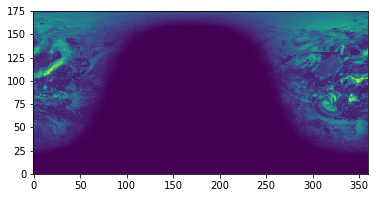

In [15]:
plt.imshow(subset[0], cmap='viridis', interpolation='nearest')
plt.ylim(0,175)
plt.show()